### Generating human faces with Adversarial Networks
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc.

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.
# data = data*2
# data = data - 1

IMG_SHAPE = data.shape[1:]

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [3]:
data.shape

(13143, 36, 36, 3)

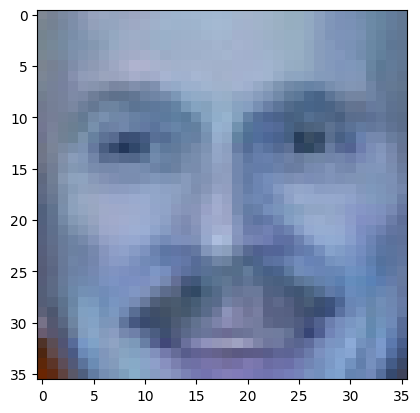

In [4]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it?
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent


The only problem is: how can we tell well-generated faces from bad?

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample.
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake.
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [5]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

In [6]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu', kernel_initializer=tf.keras.initializers.GlorotUniform()))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu', kernel_initializer=tf.keras.initializers.GlorotUniform()))

generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
generator.add(L.BatchNormalization())
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu', kernel_initializer=tf.keras.initializers.GlorotUniform()))

generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu', kernel_initializer=tf.keras.initializers.GlorotUniform()))

generator.add(L.Conv2D(3,kernel_size = 3, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform()))
#I tried using tanh and changing the input into -1;1 interval but sigmoid showed better results

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 640)               164480    
                                                                 
 reshape (Reshape)           (None, 8, 8, 10)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 64)       16064     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       102464    
 ranspose)                                                       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                        

In [ ]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
Discriminator is your usual convolutional network with interlooping convolution and pooling layers

In [7]:
from IPython.core.interactiveshell import dis
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

discriminator.add(L.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
discriminator.add(L.AveragePooling2D(2, 2)) #AveragePooling as instructed in the git repo
discriminator.add(L.BatchNormalization())
discriminator.add(L.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
discriminator.add(L.BatchNormalization())

discriminator.add(L.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
discriminator.add(L.BatchNormalization())
discriminator.add(L.Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
discriminator.add(L.AveragePooling2D(2, 2))
discriminator.add(L.BatchNormalization())
discriminator.add(L.Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
discriminator.add(L.BatchNormalization())

discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()))
discriminator.add(L.BatchNormalization())
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 18, 18, 32)        896       
                                                                 
 average_pooling2d (AverageP  (None, 9, 9, 32)         0         
 ooling2D)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 9, 9, 32)         128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 64)          18496     
                                                                 
 batch_normalization_2 (Batc  (None, 5, 5, 64)         256       
 hNormalization)                                                 
                                                      

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real

![img](gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* You can find useful tricks here https://github.com/soumith/ganhacks

### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [8]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [9]:
disc_optimizer = tf.optimizers.Adam()
gen_optimizer = tf.optimizers.Adam()

1/1 [==============================] - 0s 18ms/step


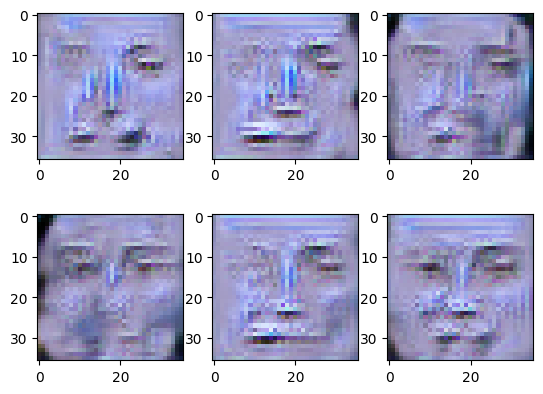

32/32 [==============================] - 0s 2ms/step


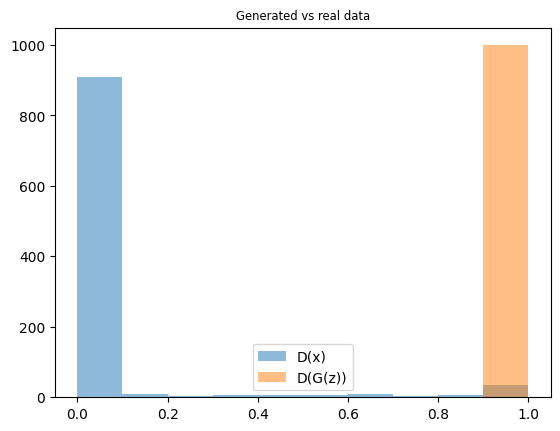

d_loss  tf.Tensor(0.14268078, shape=(), dtype=float32)
g_loss  tf.Tensor(4.2489095, shape=(), dtype=float32)
d_loss  tf.Tensor(0.019926215, shape=(), dtype=float32)
g_loss  tf.Tensor(4.4097705, shape=(), dtype=float32)
d_loss  tf.Tensor(0.057849135, shape=(), dtype=float32)
g_loss  tf.Tensor(3.8515365, shape=(), dtype=float32)
d_loss  tf.Tensor(0.265292, shape=(), dtype=float32)
g_loss  tf.Tensor(4.438829, shape=(), dtype=float32)
d_loss  tf.Tensor(0.25848517, shape=(), dtype=float32)
g_loss  tf.Tensor(4.283635, shape=(), dtype=float32)
d_loss  tf.Tensor(0.14319445, shape=(), dtype=float32)
g_loss  tf.Tensor(3.8785233, shape=(), dtype=float32)
d_loss  tf.Tensor(0.14960712, shape=(), dtype=float32)
g_loss  tf.Tensor(3.965004, shape=(), dtype=float32)
d_loss  tf.Tensor(0.34088746, shape=(), dtype=float32)
g_loss  tf.Tensor(3.9635954, shape=(), dtype=float32)
d_loss  tf.Tensor(0.40326282, shape=(), dtype=float32)
g_loss  tf.Tensor(3.4105368, shape=(), dtype=float32)
d_loss  tf.Tensor(0.19

In [47]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(200):

    real_data = sample_data_batch(100)
    noise = sample_noise_batch(100)
    ########################
    #discriminator training#
    # ########################
    for i in range(4):
        with tf.GradientTape() as disc_tape:

          logp_real = discriminator(real_data)

          generated_data = generator(noise)

          logp_gen = discriminator(generated_data)

          d_loss = -tf.reduce_mean(logp_real[:,0] + logp_gen[:,1])

          #regularize
          d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

        #optimize
        grads = disc_tape.gradient(d_loss, discriminator.trainable_weights)
        disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
    print("d_loss ", d_loss)

    ########################
    ###generator training###
    ########################

    with tf.GradientTape() as tape:

      generated_data = generator(noise)
      logp_gen = discriminator(generated_data)

      g_loss = -tf.reduce_mean(logp_gen[:, 0]) # It the git repo it was instructed to maximize the Log(D(Z(x))), rather than minimize Log(1-D(Z(x)))
      g_loss += tf.reduce_mean(generator.layers[-1].kernel**2)

    grads = tape.gradient(g_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    print("g_loss ", g_loss)


    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)


4/4 [==============================] - 0s 5ms/step


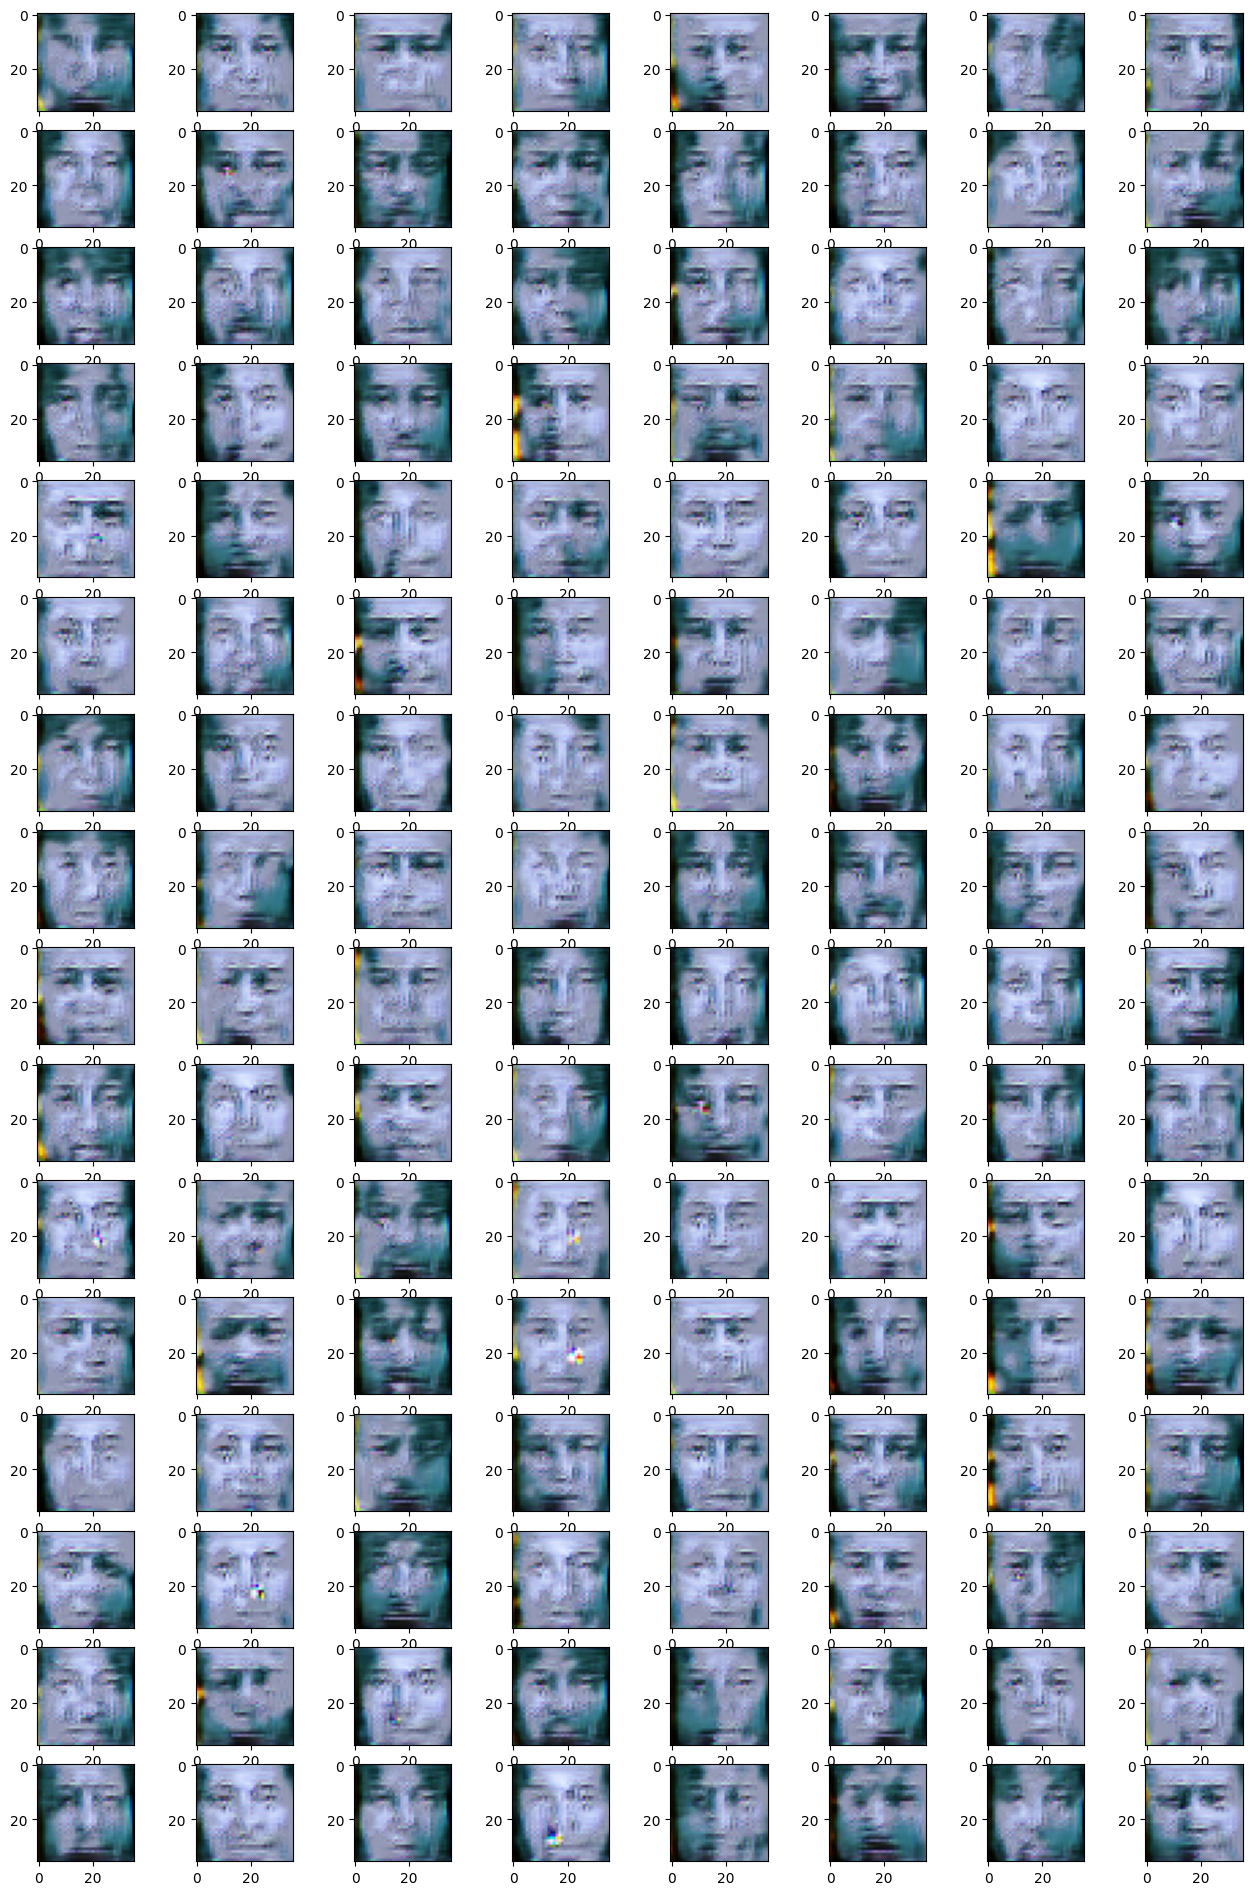

In [66]:
plt.figure(figsize=[16,24])
sample_images(16,8)
